## Document Classifier

In [1]:
!pip install -qq torchtext
!pip install -qq torchdata
!pip install torch==2.0.1+cpu torchvision==0.15.2+cpu torchtext==0.15.2+cpu --index-url https://download.pytorch.org/whl/cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.0 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 80.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu121
    Uninstalling torchvision-0.20.1+cu121:
      Successfully uninstalled torchvision-0.20.1+cu121
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.10.1
    Uninstalling torchdata

In [2]:
!pip install portalocker

In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split

from torchtext.data.utils import get_tokenizer

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [4]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

### Creating iterator and checking text, associated labels

In [5]:
train_iter= iter(AG_NEWS(split="train"))

In [6]:
size = sum(1 for _ in train_iter)  # Count the number of items
print(f"Size of train_iter: {size}")

Size of train_iter: 120000


In [7]:
train_iter= iter(AG_NEWS(split="train"))
y,text= next((train_iter))
print(y,text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [8]:
next((train_iter)) ## we can use next and keep iterating and get label, text

(3,
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')

In [9]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
ag_news_label[y]

'Business'

In [10]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class

4

## Data Preparation

1. What is an Iterable?

Definition: An iterable is any Python object that can be looped over (iterated through). It contains elements that you can access one at a time.
Key Property: An iterable implements the __iter__() method, which returns an iterator.

Examples: Lists, tuples, dictionaries, strings, and objects that define __iter__() or __getitem__(). How to Identify an Iterable

You can pass an iterable to iter() to get an iterator. **AG_NEWS is an iterable object**

The AG_NEWS dataset in torchtext does not support direct indexing like a list or tuple. It is not a random access dataset but rather an iterable dataset that needs to be used with an iterator. This approach is more effective for text data.



In [11]:

# Reinitialize train_iter, loads AG_NEWS dataset which contains labels and text, without iter. AG_NEWS is an iterable object
train_iter = AG_NEWS(split="train")


# Define tokenizer and yield_tokens
tokenizer = get_tokenizer("basic_english")

# The purpose of the generator function yield_tokens is to yield tokenized texts one at a time.
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text.lower())  # Lowercase conversion for consistency

If we had initalized AG News with iter and then called yield_tokens then it will give you list of tokens for one sentence at a time and then calling next(yield_tokens(train_iter)) will give next sentence list of tokens.

What build_vocab_from_iterator Expects?

The function build_vocab_from_iterator works with any iterable that provides tokens one at a time. It does not require an explicit iterator.
It will internally convert the iterable into an iterator using iter() if necessary.

In [12]:

# Build vocabulary, unk for unknown words
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Print the vocabulary size and sample tokens
print(f"Vocabulary size: {len(vocab)}")
print(f"Sample tokens: {list(vocab.get_stoi().keys())[:10]}")


Vocabulary size: 95811
Sample tokens: ['zzz', 'zygmunt', 'zwiki', 'zvidauri', 'zurine', 'zurab', 'zuo', 'zuloaga', 'zovko', 'zotinca']


In [13]:
vocab(["age","hello"]) ## get token indices

[2120, 12544]

### Next Steps to

Load the dataset: train_iter and test_iter hold training and test data.
Convert to map-style datasets: Make datasets compatible with random access (train_dataset and test_dataset).
Split the training dataset:
95% for training (split_train_).
5% for validation (split_valid_).
Prepare for GPU/CPU: Ensures that the training process utilizes GPU if available, otherwise defaults to CPU.


**PyTorch supports two types of datasets**:

Iterable-style datasets: Provide samples one by one (like train_iter).
Map-style datasets: Allow indexing (e.g., train_dataset[0] returns the first sample).

to_map_style_dataset converts the iterable-style dataset (train_iter) into a map-style dataset (train_dataset) so it can be indexed and used with functions like random_split.

In [14]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataloader
Prepare the text processing pipeline with the tokenizer and vocabulary. The text and label pipelines will be used to process the raw data strings from the dataset iterators.


The function text_pipeline will tokenize the input text, and vocab will then be applied to get the token indices. The label_pipeline will ensure that the labels start at zero.

In [16]:
def text_pipeline(x):
  ### tokenizer as we have already seen tokenizes the text and vocab converts these tokens into numerical indices as we have seen above.
  ## this is the preprocessing step. we first tokenize and create vocab indices exact same way using vocab defined already.
  return vocab(tokenizer(x))

def label_pipeline(x):
   ## Its purpose is to convert raw labels into numerical format
   return int(x) - 1

In PyTorch, the collate_fn function is used in conjunction with data loaders to customize the way batches are created from individual samples. The provided code defines a collate_batch function in PyTorch, which is used with data loaders to customize batch creation from individual samples. It processes a batch of data, including labels and text sequences. It applies the label_pipeline and text_pipeline functions to preprocess the labels and texts, respectively. The processed data is then converted into PyTorch tensors and returned as a tuple containing the label tensor, text tensor, and offsets tensor representing the starting positions of each text sequence in the combined tensor.




In [18]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [ ]:
split_train_

In [24]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [20]:
label, text, offsets=next(iter(valid_dataloader ))
label, text, offsets

(tensor([3, 1, 2, 3, 3, 2, 0, 0, 3, 1, 2, 3, 3, 1, 1, 2, 2, 2, 3, 3, 3, 0, 0, 1,
         1, 3, 1, 3, 2, 0, 0, 2, 1, 2, 3, 0, 1, 1, 2, 3, 2, 3, 0, 2, 0, 0, 1, 1,
         3, 0, 0, 3, 0, 2, 2, 2, 3, 1, 2, 1, 0, 3, 2, 3]),
 tensor([  195,  1840,    12,  ..., 11901, 24528,     1]),
 tensor([   0,   47,   86,  121,  167,  239,  285,  333,  362,  434,  466,  514,
          568,  613,  656,  698,  721,  761,  804,  856,  919,  975, 1004, 1046,
         1095, 1132, 1177, 1220, 1243, 1286, 1331, 1367, 1424, 1459, 1511, 1560,
         1608, 1648, 1677, 1719, 1748, 1800, 1840, 1887, 1922, 1997, 2051, 2087,
         2125, 2179, 2223, 2257, 2314, 2354, 2401, 2463, 2523, 2570, 2610, 2652,
         2704, 2751, 2807, 2844]))

In [22]:
label, text, offsets=next(iter(valid_dataloader ))
label, text, offsets

(tensor([2, 2, 2, 1, 2, 2, 3, 3, 3, 3, 1, 0, 0, 3, 0, 3, 2, 3, 0, 2, 0, 0, 0, 2,
         2, 3, 3, 3, 2, 0, 3, 0, 0, 2, 0, 3, 2, 2, 3, 1, 2, 1, 0, 0, 3, 2, 0, 3,
         3, 1, 3, 3, 2, 0, 2, 1, 3, 3, 3, 1, 2, 0, 2, 2]),
 tensor([202, 649, 178,  ...,   1, 616,   1]),
 tensor([   0,   32,   73,  108,  138,  170,  208,  245,  292,  339,  396,  447,
          509,  570,  598,  659,  699,  731,  775,  806,  846,  903,  934,  993,
         1029, 1060, 1085, 1135, 1177, 1210, 1265, 1297, 1336, 1379, 1416, 1447,
         1484, 1534, 1578, 1608, 1650, 1690, 1740, 1793, 1837, 1865, 1898, 1939,
         1977, 2061, 2124, 2178, 2208, 2245, 2300, 2348, 2394, 2438, 2473, 2521,
         2560, 2592, 2651, 2683]))

In [27]:
### As we can see we have variable length data not padded because we will be using embedding bag
for label, text, offsets in valid_dataloader:
    #print(text)
    print(len(text))


2721
2773
2788
2869
2816
2852
2624
2821
2838
2677
2893
2765
2836
2805
2819
2816
2758
2800
2839
2831
2876
2743
2816
2841
2673
2989
3024
2641
2646
2681
2889
2641
2700
2869
2656
2744
2773
2697
2770
2648
2770
2804
2702
2897
2875
2796
2592
2871
2604
2634
2529
2675
2794
2791
2746
2708
2818
2895
2682
2496
2713
2794
2745
2883
2973
2937
2744
2757
2752
2634
2765
2592
2805
2804
2928
2690
2872
2852
2621
2990
2752
2897
2893
2725
2868
2699
2622
2772
2800
2936
2711
2860
2621
1941


1. Why is Padding Usually Needed?

In text processing tasks with models like RNNs or Transformers, padding is required when:

Sentences have variable lengths.

Since models process inputs in batches, all sentences in a batch must have the same length. Padding ensures this by adding extra tokens (e.g., <pad>) to shorter sentences.


2. Why No Padding with nn.EmbeddingBag?

nn.EmbeddingBag handles variable-length sequences in a more efficient way, so padding is unnecessary. Instead, it uses:

A flattened input tensor (text): This contains all the token indices for the entire batch, concatenated into a single tensor.

An offsets tensor (offsets): This marks the starting index of each sentence in the flattened tensor.

3. How nn.EmbeddingBag Works Without Padding

Consider a batch of 3 sentences:

Sentence 1: [1, 2, 3]

Sentence 2: [4, 5]

Sentence 3: [6, 7, 8, 9]

Instead of padding, nn.EmbeddingBag:

Flattens the sentences into a single tensor:

text = [1, 2, 3, 4, 5, 6, 7, 8, 9]

Creates an offsets tensor to indicate where each sentence starts:

offsets = [0, 3, 5]  # Sentence 1 starts at index 0, Sentence 2 at index 3, Sentence 3 at index 5

During the forward pass:

nn.EmbeddingBag uses the offsets to determine which tokens belong to each sentence.

It directly computes the aggregated embedding for each sentence by summing or averaging the embeddings of the tokens (without needing padding).

4. Advantages of Not Using Padding

Efficiency:

Padding adds unnecessary computations for the padded tokens, especially if sentences have highly variable lengths.
nn.EmbeddingBag avoids this by only processing actual tokens, leading to faster and more memory-efficient training.

Simplified Preprocessing:

You don’t need to manually pad sentences to the same length.
The collate_batch function only needs to flatten the token indices and create the offsets tensor, which is simpler than handling padding.

In [28]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [30]:
emsize=64
vocab_size=len(vocab)
vocab_size

95811

In [31]:
num_class

4

In [32]:
## creating model
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
model

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

The code line predicted_label=model(text, offsets) is used to obtain predicted labels from a machine learning model for a given input text and its corresponding offsets. The model is the machine learning model being used for text classification or similar tasks.

it triggers the forward() method of the TextClassificationModel class. In PyTorch, calling a model instance like model(text, offsets) implicitly invokes the forward() method defined in the model.


In [33]:
predicted_label=model(text, offsets)

In [35]:
predicted_label.shape

torch.Size([48, 4])

In [36]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0])) ### predict and then return the max
        return ag_news_label[output.argmax(1).item() + 1]

In [37]:
predict("I like sports",text_pipeline )

'Business'

### Evaluation

In [38]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [39]:
evaluate(test_dataloader)

0.24921052631578947

The model was evaluated, and it was found that its performance is no better than average. This outcome is expected, considering that the model has not undergone any training yet.


## Train the model

Set the learning rate (LR) to 0.1, which determines the step size at which the optimizer updates the model's parameters during training. The CrossEntropyLoss criterion is used to calculate the loss between the model's predicted outputs and the ground truth labels. This loss function is commonly employed for multi-class classification tasks.

The chosen optimizer is Stochastic Gradient Descent (SGD), which optimizes the model's parameters based on the computed gradients with respect to the loss function. The SGD optimizer uses the specified learning rate to control the size of the weight updates.

Additionally, a learning rate scheduler is defined using StepLR. This scheduler adjusts the learning rate during training, reducing it by a factor (gamma) of 0.1 after every epoch (step) to improve convergence and fine-tune the model's performance. These components together form the essential setup for training a neural network using the specified learning rate, loss criterion, optimizer, and learning rate scheduler.


In [40]:
LR=0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [41]:
EPOCHS = 10
cum_loss_list=[]
acc_epoch=[]
acc_old=0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    cum_loss=0
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cum_loss+=loss.item()

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

100%|██████████| 10/10 [06:55<00:00, 41.50s/it]


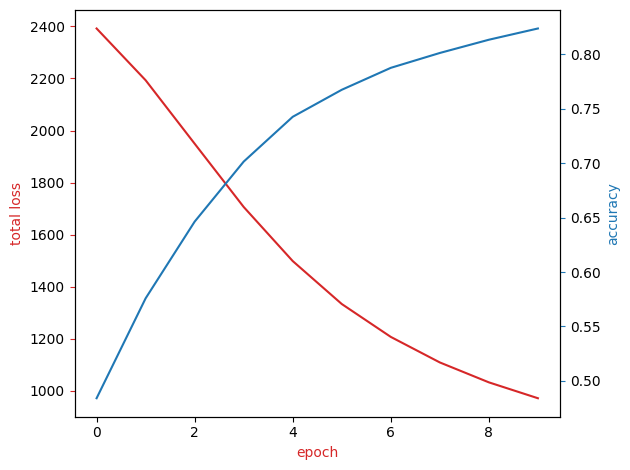

In [42]:
plot(cum_loss_list,acc_epoch)

In [43]:
evaluate(test_dataloader)

0.8194736842105264

This code snippet provides a summary for generating a 3D t-SNE visualization of embeddings using Plotly. It demonstrates how words that are similar to each other are positioned closer together.

In [44]:
# Get the first batch from the validation data
batch = next(iter(valid_dataloader))

# Extract the text and offsets from the batch
label, text, offsets = batch

# Send the data to the device (GPU if available)
text = text.to(device)
offsets = offsets.to(device)

# Get the embeddings bag output for the batch
embedded = model.embedding(text, offsets)

# Convert the embeddings tensor to a numpy array
embeddings_numpy = embedded.detach().cpu().numpy()

# Perform t-SNE on the embeddings to reduce their dimensionality to 3D.
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings_numpy)

# Create a 3D scatter plot using Plotly
trace = go.Scatter3d(
    x=X_embedded_3d[:, 0],
    y=X_embedded_3d[:, 1],
    z=X_embedded_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label.numpy(),  # Use label information for color
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

layout = go.Layout(title="3D t-SNE Visualization of Embeddings",
                   scene=dict(xaxis_title='Dimension 1',
                              yaxis_title='Dimension 2',
                              zaxis_title='Dimension 3'))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

### Lets make prediction


In [45]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

In [46]:
result = predict(article, text_pipeline)

markdown_content = f'''
<div style="background-color: lightgray; padding: 10px;">
    <h3>{article}</h3>
    <h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)


<div style="background-color: lightgray; padding: 10px;">
    <h3>Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points.</h3>
    <h4>The category of the news article: Sports</h4>
</div>


In [ ]:

###for any new articles, new_artiles is a list of articles with text. Use this to predict
for i, article in enumerate(new_articles, start=1):
    prediction = predict(article, text_pipeline)
    print(f"Article {i} is classified as: {prediction}\n")